In [58]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ['Normal', 'Fraud']

In [59]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [60]:
df.shape

(170463, 31)

In [62]:
df.isnull().values.any()

True

## Checking number of records of each kind of transcation classs(Fraud and Non-fraud

Text(0, 0.5, 'Frequency')

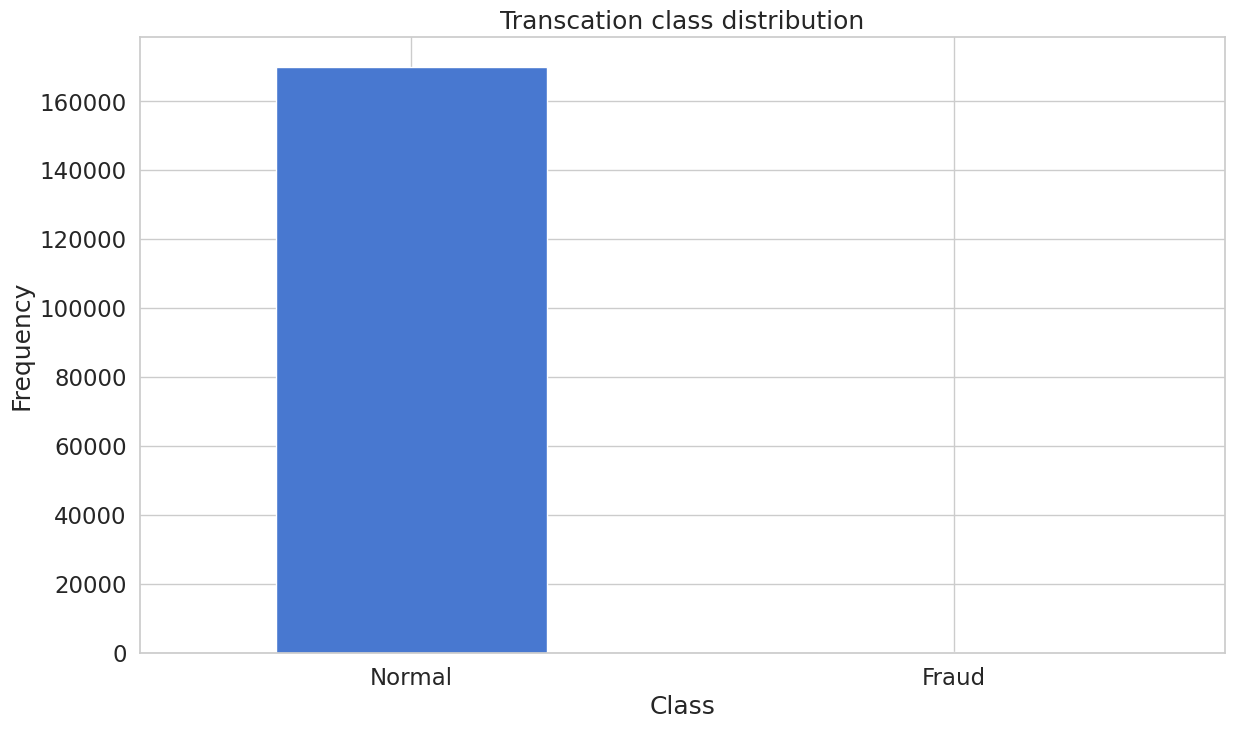

In [63]:
count_classes = pd.value_counts(df["Class"], sort = True)
count_classes.plot(kind = "bar", rot=0)
plt.title("Transcation class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [64]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(360, 31)

In [65]:
normal.shape

(170102, 31)

## Checking the amount of money involved in each kind of transaction

In [66]:
# Fraud transcations
frauds.Amount.describe()

count     360.000000
mean      111.576722
std       227.309252
min         0.000000
25%         1.000000
50%        11.385000
75%       104.007500
max      1809.680000
Name: Amount, dtype: float64

In [67]:
# Non-fraud transcations
normal.Amount.describe()

count    170102.000000
mean         87.272509
std         246.067820
min           0.000000
25%           5.490000
50%          21.890000
75%          76.500000
max       19656.530000
Name: Amount, dtype: float64

## Graphical representation of Amount

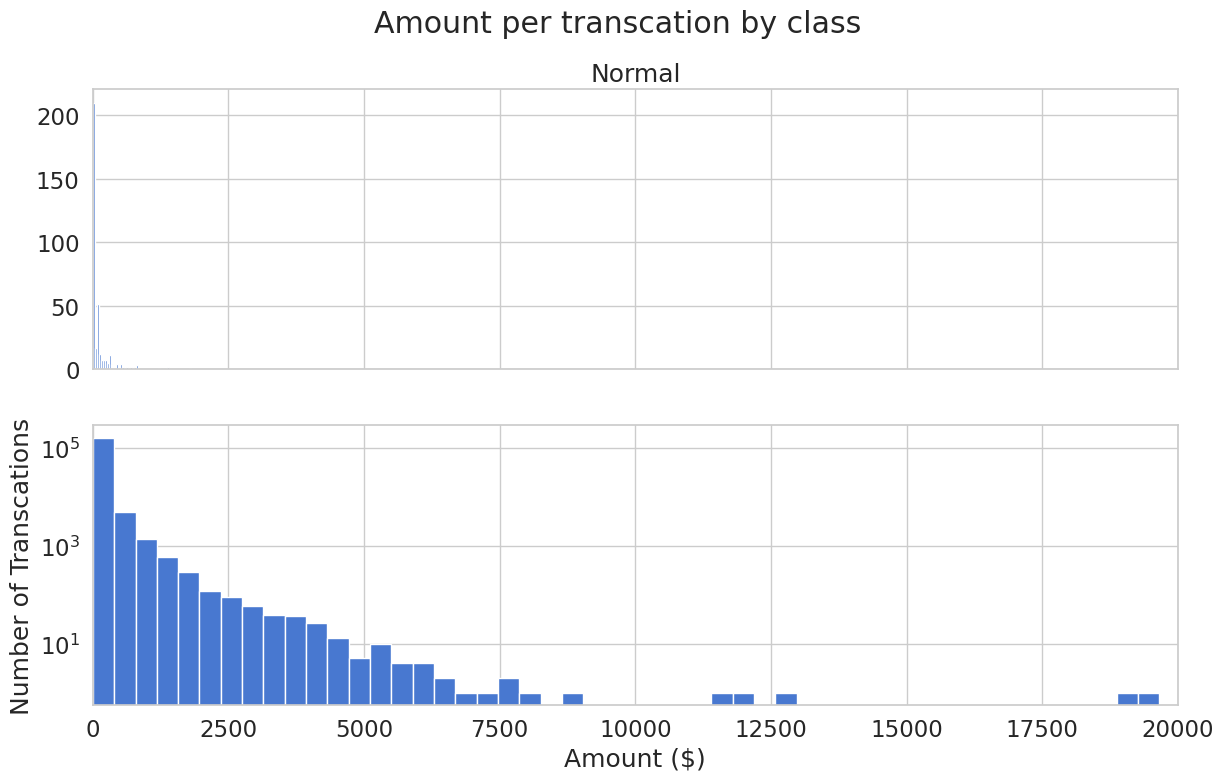

In [68]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle("Amount per transcation by class")
bins = 50
ax1.hist(frauds.Amount, bins = bins)
ax1.set_title("Fraud")
ax2.hist(normal.Amount, bins = bins)
ax1.set_title("Normal")
plt.xlabel("Amount ($)")
plt.ylabel("Number of Transcations")
plt.xlim((0, 20000))
plt.yscale("log")

plt.show()

## Plotting time of transaction to check for correlations

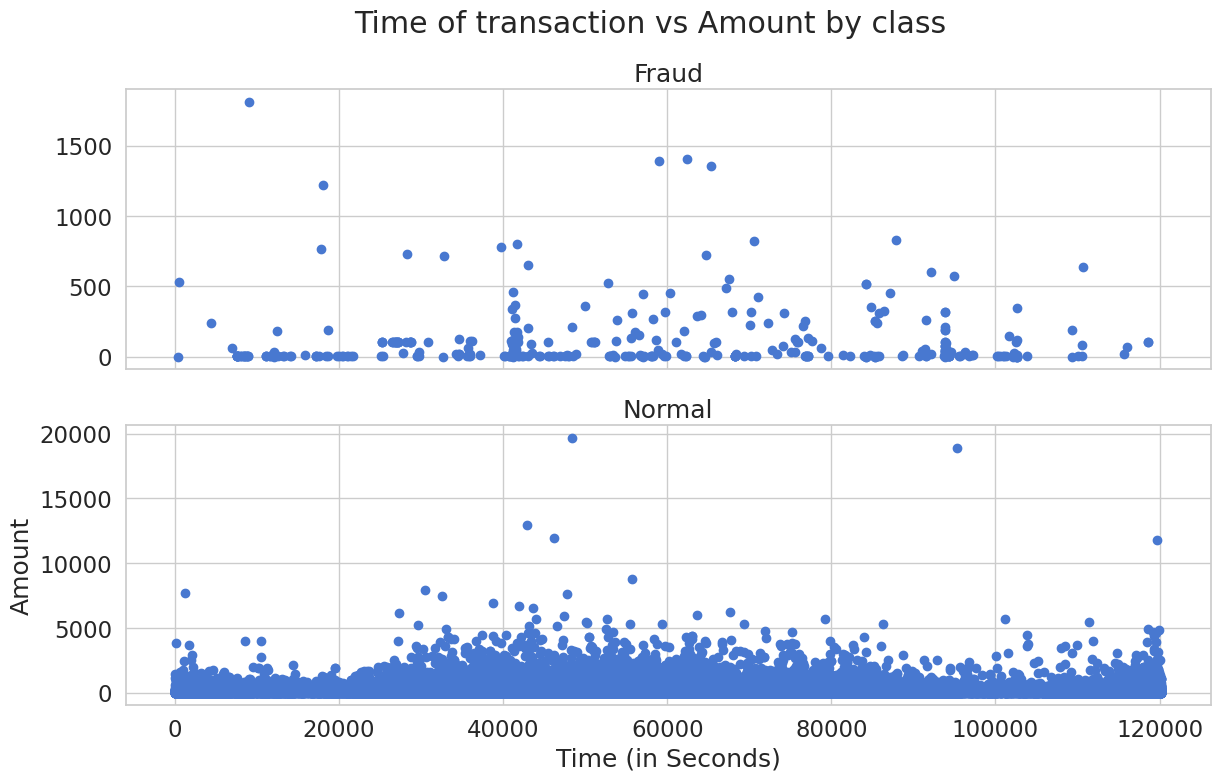

In [69]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle("Time of transaction vs Amount by class")

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title("Fraud")

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title("Normal")

plt.xlabel("Time (in Seconds)")
plt.ylabel("Amount")
plt.show()

In [70]:
data = df.drop(['Time'], axis=1)

## Scaling the Amount using StandardScalar

In [71]:
from sklearn.preprocessing import StandardScaler

data['scaled_amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Building the model

In [72]:
import pandas as pd

# Assuming 'data' is your DataFrame
non_fraud = data[data['Class'] == 0]
fraud = data[data['Class'] == 1]

# Combine the two DataFrames and shuffle
df = pd.concat([non_fraud, fraud]).sample(frac=1).reset_index(drop=True)

# Separate features and target variable
X = df.drop(['Class'], axis=1).values
Y = df['Class'].values


## Spliting the data into 80% training and 20% testing

In [73]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train_fraud = X_train[X_train.Class == 1]
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(136088, 30)

## Autoencoder Model

In [74]:
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## Output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

## Training the credit card fraud detection model

In [75]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer='adadelta', loss='mse')

## Scaling the values

In [76]:
x = data.drop(['Class'], axis=1)
y = data['Class'].values

x_scale = MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

autoencoder.fit(x_norm[0:2000], x_norm[0:2000],
batch_size = 256, epochs = 10,
                shuffle = True, validation_split = 0.20)

Epoch 1/10
7/7 [==============================] - 1s 59ms/step - loss: 0.2137 - val_loss: 0.2119
Epoch 2/10
7/7 [==============================] - 0s 13ms/step - loss: 0.2133 - val_loss: 0.2116
Epoch 3/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2129 - val_loss: 0.2112
Epoch 4/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2125 - val_loss: 0.2108
Epoch 5/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2121 - val_loss: 0.2104
Epoch 6/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2117 - val_loss: 0.2100
Epoch 7/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2113 - val_loss: 0.2096
Epoch 8/10
7/7 [==============================] - 0s 15ms/step - loss: 0.2109 - val_loss: 0.2092
Epoch 9/10
7/7 [==============================] - 0s 16ms/step - loss: 0.2105 - val_loss: 0.2087
Epoch 10/10
7/7 [==============================] - 0s 13ms/step - loss: 0.2101 - val_loss: 0.2083


## Obtain the hidden representation

In [77]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

## Model Prediction

In [78]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

12/12 [==============================] - 0s 2ms/step


## Getting the representation data

In [79]:
rep_x = np.concatenate((norm_hid_rep, fraud_hid_rep), axis=0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

## Train, Test and Split

In [80]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

## Credit Card Fraud Detection Prediction Model

In [81]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Assuming train_x, train_y, val_x, and val_y are already defined
clf = LogisticRegression(solver='lbfgs').fit(train_x, train_y)
pred_y = clf.predict(val_x)

print('')
print('Classification Report:')
print(classification_report(val_y, pred_y))

print('')
print('Accuracy Score:', accuracy_score(val_y, pred_y))



Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       750
         1.0       1.00      0.63      0.78        90

    accuracy                           0.96       840
   macro avg       0.98      0.82      0.88       840
weighted avg       0.96      0.96      0.96       840


Accuracy Score: 0.9607142857142857
